In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax_cosmo as jc

import cloudpickle as pickle


def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

def reshape_data(dat):
    realpart = dat[:, ::2, :, :]
    impart = dat[:, 1::2, :, :]

    return jnp.stack([realpart, impart], axis=-1)

# compute MOPED vectors for power spectra

$$ t = \nabla \mu_*^T C^{-1}_* (d - \mu) $$

In [2]:
### ------------- IMNN PARAMETERS -------------
θ_fid = jnp.array([0.3, 0.800]) # CHANGE TO OmegaM=0.6
δθ = jnp.array([0.0115, 0.015])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))

n_summaries = 2

n_s = 1000
n_d = 250

n_params = 2
n_summaries = n_params
print(θ_der)

[[0.29425 0.8    ]
 [0.3     0.7925 ]
 [0.30575 0.8    ]
 [0.3     0.8075 ]]


In [3]:
0.8 - 0.785, 0.3 - 0.2885

(0.015000000000000013, 0.01150000000000001)

In [4]:
pwd

'/home/makinen/repositories/alfi_lensing/sunglass_analysis/moped_notebooks'

In [5]:
# first load all data
datadir = "/data101/makinen/borg_sunglass/"

import sys,os

folders = ["omegaM", "sigma8", "fiducial", "prior"]
#folders = ["prior"]


def get_fiducial(
                 sim_path = "/data101/makinen/borg_sunglass/fiducial/",
                 data_folder = "/Cls/",
                 num_sims=1000):

    sim_path = sim_path + data_folder

    dir_list = os.listdir(sim_path)[:num_sims]
    
    sim_index = []
    sims = []
    
    for filename in dir_list:
        sim = np.load(sim_path + filename)
        sims.append(sim)
    
    return np.array(sims)


def get_all_derivatives(num_sims, 
                        n_params=2, 
                        sim_path = "/data101/makinen/borg_sunglass/",
                        data_folder = "/Cls/",
                        params=["omegaM", "sigma8"],
                        θ_fid=θ_fid,
                        δθ=δθ):
    n_params = len(params)
    derivative_sims = [] #[[]]*n_params
    
    derivative_param_values = [] # [[]]*n_params

    # go through each seed index
    for i in range(num_sims):
        # go through each parameter
        for j,p in enumerate(params):
            
            try:
                sim_folder = sim_path + p + data_folder
                #print(sim_folder)

                # try loading plus and minus sims
                minus_value = θ_fid[j] - δθ[j]
                if p == "sigma8":
                    filename = sim_folder + "sim_%.3f_%d.npy"%(minus_value, i)
                else:
                    filename = sim_folder + "sim_%.4f_%d.npy"%(minus_value, i)
                    
                #print(filename)
                minus_sim = np.load(filename)
                
                plus_value = θ_fid[j] + δθ[j]
                if p == "sigma8":
                    filename = sim_folder + "sim_%.3f_%d.npy"%(plus_value, i)
                else:
                    filename = sim_folder + "sim_%.4f_%d.npy"%(plus_value, i)
                plus_sim = np.load(filename)
                #print(filename)
                
                derivative_sims.append(minus_sim)
                derivative_sims.append(plus_sim)
                
                derivative_param_values.append(minus_value)
                derivative_param_values.append(plus_value)
                
            except:
                print("missed idx", i)
                pass
            
    derivative_sims = np.array(derivative_sims)
    
    print("collected derivative sims: ", derivative_sims.shape)
    
    outs = np.zeros((len(derivative_sims),) + derivative_sims.shape[1:])
    #print(outs.shape)
    
    outs[0::4, ...] = derivative_sims[0::4, ...]
    outs[1::4, ...] = derivative_sims[2::4, ...]
    outs[2::4, ...] = derivative_sims[1::4, ...]
    outs[3::4, ...] = derivative_sims[3::4, ...]
    
    print("output: ", outs.shape)
    
    # stack them -,-,+,+,...
    #for j in range(n_params):
       # for q in range(2):
    
       # outs[j*::2*n_params, ...] = derivative_sims[j][::2, ...] # minus sims per param
       # outs[j+1::2*n_params, ...] = derivative_sims[j][1::2, ...] # plus sims per param
        
    return outs #, np.array(derivative_param_values)

In [8]:
n_d = 200

dervs = get_all_derivatives(num_sims=n_d*2)[:, 4:, 1] # first idx is the ells
fiducial = get_fiducial(num_sims=2000)[:, 4:, 1]

dervs *= 1e7
fiducial *= 1e7

dervs += 1
fiducial += 1

dervs = np.log(dervs)
fiducial = np.log(fiducial)

#dervs = jnp.arcsinh(dervs)
#fiducial = jnp.arcsinh(fiducial)

dervs.shape, fiducial.shape

collected derivative sims:  (1600, 64, 2)
output:  (1600, 64, 2)


((1600, 60), (1995, 60))

In [27]:
np.save("dervs", dervs)
np.save("fid", fiducial)

In [8]:
pwd

'/home/makinen/repositories/alfi_lensing/sunglass_analysis/moped_notebooks'

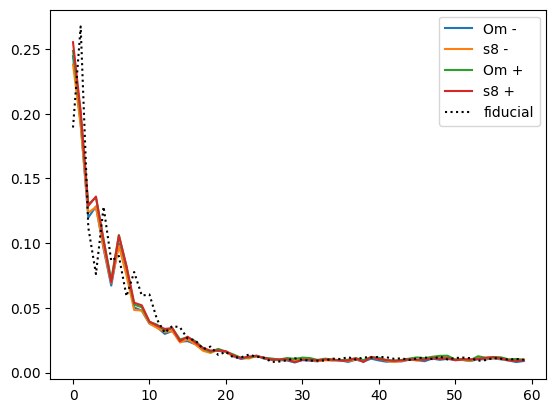

In [9]:
plt.plot(dervs[0], label='Om -')
plt.plot(dervs[1], label='s8 -')

plt.plot(dervs[2], label='Om +')

plt.plot(dervs[3], label='s8 +')

plt.plot(fiducial[0], c='k', ls=':', label='fiducial')

#plt.plot(Cls_prior[:, 1], c='green', ls='-', label='s8=1.3967')

#plt.loglog()
plt.legend()


In [10]:
# # histogram the spectra
# dervs = jnp.array(dervs)
# fid = jnp.array(fiducial)

# _hist = lambda d: jnp.histogram(d, bins=4)[0]
# dervs = jax.vmap(_hist)(dervs)
# fiducial = jax.vmap(_hist)(fid)


In [11]:
dervs.shape, fiducial.shape

((1600, 60), (1995, 60))

In [12]:
# for m in np.arange(500):
#     if m not in plus_sim_index:
#         print(m)

In [13]:
om_min = 0.2885
om_plus = 0.3115

In [14]:
0.3 - om_min, om_plus - 0.3

(0.01150000000000001, 0.01150000000000001)

In [15]:
### ------------- IMNN PARAMETERS -------------
θ_fid = jnp.array([0.3, 0.800]) # CHANGE TO OmegaM=0.6
δθ = 2*jnp.array([0.0115, 0.015])

θ_der = (θ_fid + jnp.einsum("i,jk->ijk", jnp.array([-1., 1.]), jnp.diag(δθ) / 2.)).reshape((-1, 2))

n_summaries = 2

n_s = 1000
n_d = 125

n_params = 2
n_summaries = n_params
print(θ_der)

[[0.2885 0.8   ]
 [0.3    0.785 ]
 [0.3115 0.8   ]
 [0.3    0.815 ]]


In [17]:
# now get MOPED vector components

full_fid = np.array(fiducial)
full_dervs = np.array(dervs)

n_d = 200 * 2
n_s = len(full_fid)

# first inverse covariance 

# get covariance from fiducial sims
C = np.cov(full_fid.reshape(-1, full_fid.shape[-1]), rowvar=False)
invC = np.linalg.inv(C)


mu = np.mean(full_fid, 0)

# next mean of derivatives

# get derivatives
δθ = 2*jnp.array([0.0115, 0.015])
n_param = 2

x_mp = full_dervs.reshape(n_d, 2, n_param, full_dervs.shape[-1])

# compute finite-differences for derivatives
_dervs = (x_mp[:, 1, :, :] - x_mp[:, 0, :, :]) / np.expand_dims(np.expand_dims(δθ, 0), -1)

mu_dervs = np.mean(_dervs, 0)

In [18]:
_dervs.shape

(400, 2, 60)

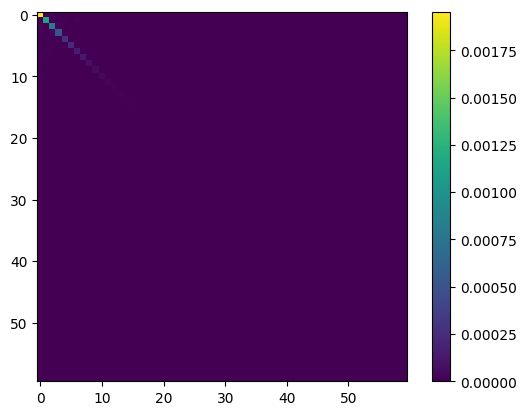

In [19]:
%matplotlib inline

# visualize covariance matrix
plt.imshow((C), vmin=0)
plt.colorbar()

In [20]:
# check that covariance is well-estimated
eigs,evecs = np.linalg.eig(C)
print('minimum eigenvalue', np.min(eigs))
print('maximum eigenvalue', np.max(eigs))

minimum eigenvalue 4.2192453478290815e-07
maximum eigenvalue 0.0019579182150249587


Text(0, 0.5, 'mean derivatives for $C\\ell s$')

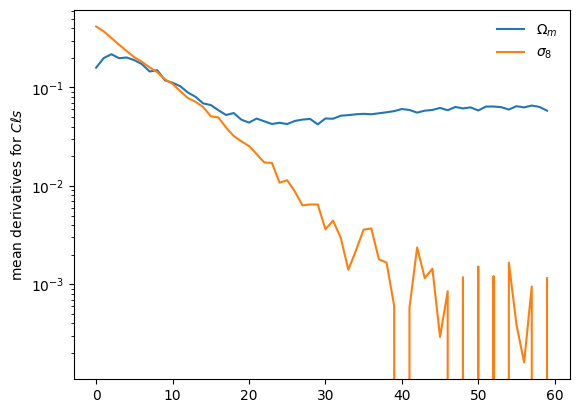

In [21]:
plt.plot(mu_dervs[0, :], label="$\Omega_m$")
plt.plot(mu_dervs[1, :], label=r"$\sigma_8$")
plt.legend(framealpha=0.0)
plt.yscale("log")
plt.ylabel("mean derivatives for $C\ell s$")

# bonus: calculate analytic Fisher matrix

In [22]:
F = np.einsum("ij,jl,kl->ik", mu_dervs, invC, mu_dervs)


In [23]:
F

array([[22045.73252133,  2843.51237204],
       [ 2843.51237204,  4453.72930052]])

In [24]:
print("fisher (shannon) information:", 0.5*np.log(np.linalg.det(F)), "nats")

print("fisher (shannon) information:", 0.5*np.log2(np.linalg.det(F)), "bits")

fisher (shannon) information: 9.158216261797026 nats
fisher (shannon) information: 13.21251318428323 bits


In [25]:
np.linalg.inv(F)

array([[ 4.94308688e-05, -3.15594589e-05],
       [-3.15594589e-05,  2.44680275e-04]])

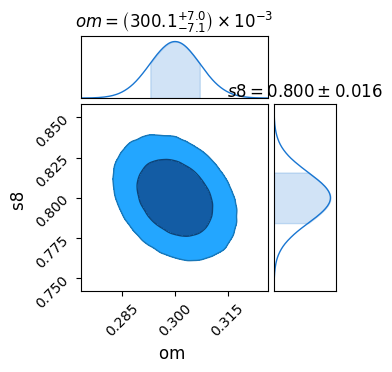

In [26]:
from chainconsumer import ChainConsumer

parameters = ['om', 's8']

Cplot = np.array(np.linalg.inv(F))

cs = ChainConsumer()
cs.add_covariance(mean=np.array(θ_fid), covariance = Cplot, parameters=parameters)
cs.configure(usetex=False, serif=False)
cs.plotter.plot()
plt.show()

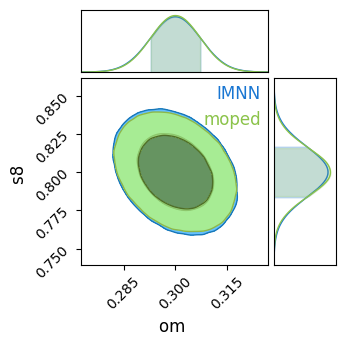

In [30]:
from chainconsumer import ChainConsumer

parameters = ['om', 's8']

IMNN_F_new = np.array([[21233.393 ,  2762.8047],
        [ 2762.805 ,  4068.3545]])

cs = ChainConsumer()
cs.add_covariance(mean=np.array(θ_fid), covariance = np.linalg.inv(IMNN_F_new), parameters=parameters, name="IMNN")
cs.add_covariance(mean=np.array(θ_fid), covariance = np.linalg.inv(F), parameters=parameters, name="moped")

#cs.configure(usetex=False, serif=False)
cs.plotter.plot()
plt.show()

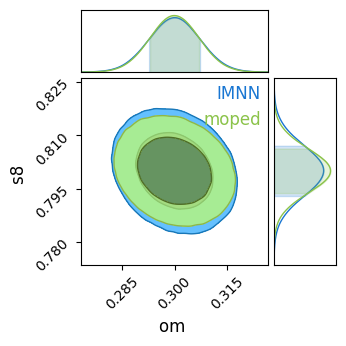

In [42]:
from chainconsumer import ChainConsumer

parameters = ['om', 's8']

IMNN_F = np.array([[20413.395 ,  4184.5166],
        [ 4184.517 , 21088.354 ]])

cs = ChainConsumer()
cs.add_covariance(mean=np.array(θ_fid), covariance = np.linalg.inv(IMNN_F), parameters=parameters, name="IMNN")
cs.add_covariance(mean=np.array(θ_fid), covariance = np.linalg.inv(F), parameters=parameters, name="moped")

#cs.configure(usetex=False, serif=False)
cs.plotter.plot()
plt.show()

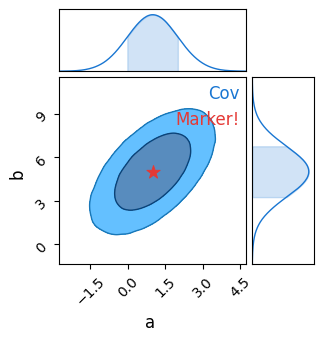

In [27]:
mean = [1, 5]
cov = [[1, 1], [1, 3]]
parameters = ["a", "b"]

c = ChainConsumer()
c.add_covariance(mean, cov, parameters=parameters, name="Cov")
c.add_marker(mean, parameters=parameters, name="Marker!", marker_style="*", marker_size=100, color="r")
c.configure(usetex=False, serif=False)
fig = c.plotter.plot()

# compute summaries over a prior

In [160]:
# now load in all the prior data and compress using the MOPED scheme

X = jnp.load(datadir + "noisefree_prior_sims.npy")[:5000]
y = jnp.load(datadir + "noisefree_prior_params.npy")[:5000]

X = reshape_data(X)


key = jax.random.PRNGKey(8)
keys = jax.random.split(key, num=X.shape[0])
X = jax.vmap(noise_simulator)(keys, X)

X = jax.vmap(field_to_pk)(X)

In [161]:
mu_dervs.shape, invC.shape

((2, 240), (240, 240))

In [162]:
mu_dervs.shape

(2, 240)

In [163]:
# next compress

deltas = (X - mu)

score_vectors = jnp.einsum("mi,ij,jk->mk", mu_dervs, invC, deltas.T).T

In [164]:
max_scores = score_vectors.max()

In [165]:
max_scores

Array(1332.866, dtype=float32)

In [166]:
score_vectors /= max_scores

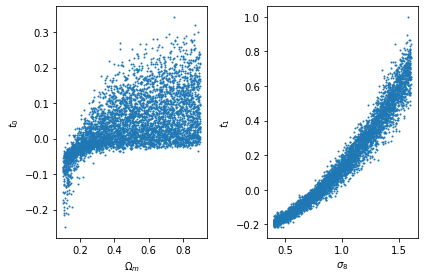

In [167]:
plt.subplot(121)
plt.scatter(y[:, 0], score_vectors[:, 0], s=1)
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$t_0$")

plt.subplot(122)
plt.scatter(y[:, 1], score_vectors[:, 1], s=1)
plt.xlabel(r"$\sigma_8$")
plt.ylabel(r"$t_1$")
plt.tight_layout()

In [140]:
# save score vectors

np.save("/Users/lucas/Datasets/imnn_borg/score_vectors", score_vectors)
np.save("/Users/lucas/Datasets/imnn_borg/score_parameters", y)

In [23]:
# load mock data

#### ------------- get Natalia's target data WITH NOISE -------------
print("loading mock data for obtaining estimates")

import numpy as onp
np = onp
import h5py as h5



def get_data(f):
	dataR = np.zeros((4, 64, 64))
	dataI = np.zeros((4, 64, 64))

	bin0 = f['tomo0'][:]
	bin1 = f['tomo1'][:]
	bin2 = f['tomo2'][:]
	bin3 = f['tomo3'][:]

	data = np.stack([bin0,bin1,bin2,bin3])

	dataR = np.real(data)
	dataI = np.imag(data)

	return dataR, dataI


path = datadir
f = h5.File(path + 'mock_data_fields.h5', 'r')

targetR, targetI = get_data(f)

_dat = onp.ones((8, 64, 64))
_dat[::2, :, :] = targetR
_dat[1::2, :, :] = targetI

np=jnp
_dat = jnp.array(_dat)


target_data = jnp.squeeze(reshape_data(_dat[jnp.newaxis, :, :, :]))

target_data = noise_simulator(jax.random.PRNGKey(99), target_data)

#adjustment = noisevars
#target_data = target_data*(1. / (jnp.sqrt(adjustment).reshape(4, 1, 1, 1)))

loading mock data for obtaining estimates


In [24]:
target_data = field_to_pk(target_data)

In [25]:
delta_target = (target_data - mu)[jnp.newaxis, :]

score_estimates = jnp.einsum("mi,ij,jk->mk", mu_dervs, invC, delta_target.T).T

In [26]:
score_estimates /= max_scores

In [27]:
score_estimates

Array([[-0.00721374, -0.01805398]], dtype=float32)

In [146]:
np.save("/Users/lucas/Datasets/imnn_borg/score_estimates", score_estimates)

In [29]:
# save the components necessary for score compression
np.save("/Users/lucas/Datasets/imnn_borg/moped_pk_dervs", mu_dervs)
np.save("/Users/lucas/Datasets/imnn_borg/moped_pk_mu", mu)
np.save("/Users/lucas/Datasets/imnn_borg/moped_pk_invC", invC)


In [46]:
jnp.log(X +1).min()

Array(-0.0536294, dtype=float32)